In [101]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from statsmodels.graphics.gofplots import qqplot

In [102]:
Employee_table=pd.read_csv('Employee.csv')


In [103]:
Employee_table["HireDate"] = pd.to_datetime(Employee_table["HireDate"])
Employee_table['ExitDate'] = Employee_table.apply(
    lambda row: row['HireDate'] + pd.DateOffset(years=row['YearsAtCompany']) if row['Attrition'] == 'Yes' else 'Still Working',
    axis=1
)


In [104]:
df_left = Employee_table[Employee_table["Attrition"] == "Yes"]

df_left["ExitDate"] = pd.to_datetime(df_left["ExitDate"])



C:\Users\Ard Al Jood\AppData\Local\Temp\ipykernel_9924\1720794919.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_left["ExitDate"] = pd.to_datetime(df_left["ExitDate"])


In [150]:
df_left.info()

<class 'pandas.core.frame.DataFrame'>
Index: 237 entries, 4 to 1457
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   EmployeeID               237 non-null    object        
 1   FirstName                237 non-null    object        
 2   LastName                 237 non-null    object        
 3   Gender                   237 non-null    object        
 4   Age                      237 non-null    int64         
 5   BusinessTravel           237 non-null    object        
 6   Department               237 non-null    object        
 7   DistanceFromHome (KM)    237 non-null    int64         
 8   State                    237 non-null    object        
 9   Ethnicity                237 non-null    object        
 10  Education                237 non-null    int64         
 11  EducationField           237 non-null    object        
 12  JobRole                  237 non-null   

In [105]:

# Aggregate monthly attrition counts
df_left["ExitMonth"] = df_left["ExitDate"].dt.to_period("M")
attrition_time_series = df_left.groupby("ExitMonth").size().rename("AttritionCount")

# Convert to a proper time series format
attrition_time_series = attrition_time_series.to_timestamp()

# Display the first few rows of the aggregated attrition time series
attrition_time_series.head()

C:\Users\Ard Al Jood\AppData\Local\Temp\ipykernel_9924\3523149406.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_left["ExitMonth"] = df_left["ExitDate"].dt.to_period("M")


ExitMonth
2013-04-01    1
2013-05-01    1
2014-02-01    1
2014-03-01    2
2014-05-01    1
Name: AttritionCount, dtype: int64

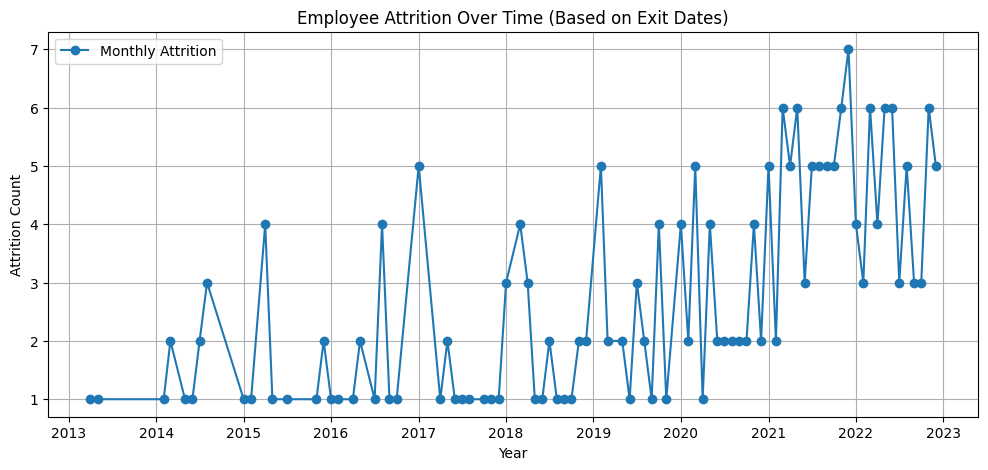

In [106]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(attrition_time_series, marker="o", linestyle="-", label="Monthly Attrition")
plt.xlabel("Year")
plt.ylabel("Attrition Count")
plt.title("Employee Attrition Over Time (Based on Exit Dates)")
plt.legend()
plt.grid(True)
plt.show()


#### Test if the series stationary or no 

In [107]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
adf_test = adfuller(attrition_time_series.dropna())

# Extract results
adf_result = {
    "ADF Statistic": adf_test[0],
    "p-value": adf_test[1],
    "Critical Values": adf_test[4]
}

adf_result


{'ADF Statistic': np.float64(-2.0555734986540966),
 'p-value': np.float64(0.2627496339889417),
 'Critical Values': {'1%': np.float64(-3.5097356063504983),
  '5%': np.float64(-2.8961947486260944),
  '10%': np.float64(-2.5852576124567475)}}

##### the series has unite root so it's not stationary  will apply the first difference method  

In [108]:
# Apply first-order differencing
attrition_diff = attrition_time_series.diff().dropna()

# Perform ADF test on differenced data
adf_test_diff = adfuller(attrition_diff)

# Extract results
adf_result_diff = {
    "ADF Statistic": adf_test_diff[0],
    "p-value": adf_test_diff[1],
    "Critical Values": adf_test_diff[4]
}

adf_result_diff


{'ADF Statistic': np.float64(-8.536868996624035),
 'p-value': np.float64(1.0024995849414696e-13),
 'Critical Values': {'1%': np.float64(-3.510711795769895),
  '5%': np.float64(-2.8966159448223734),
  '10%': np.float64(-2.5854823866213152)}}

In [109]:
from statsmodels.tsa.stattools import  kpss

In [110]:
kpss_stat, kpss_p, *_ = kpss(attrition_diff, regression='c')
print(f"KPSS p-value: {kpss_p:.3f}  → {'stationary' if kpss_p>0.05 else 'non-stationary'}")

KPSS p-value: 0.100  → stationary


C:\Users\Ard Al Jood\AppData\Local\Temp\ipykernel_9924\3451859761.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, kpss_p, *_ = kpss(attrition_diff, regression='c')


### After applying the first differencing method and test the series now stationary 

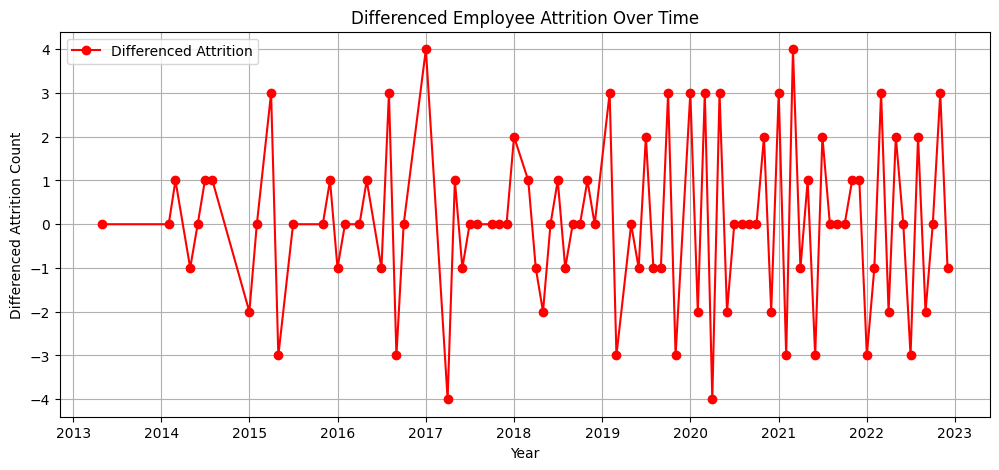

In [111]:

plt.figure(figsize=(12, 5))
plt.plot(attrition_diff, marker="o", linestyle="-", color="red", label="Differenced Attrition")
plt.xlabel("Year")
plt.ylabel("Differenced Attrition Count")
plt.title("Differenced Employee Attrition Over Time")
plt.legend()
plt.grid(True)
plt.show()


#### now the series stationary and ready  to apply the model 

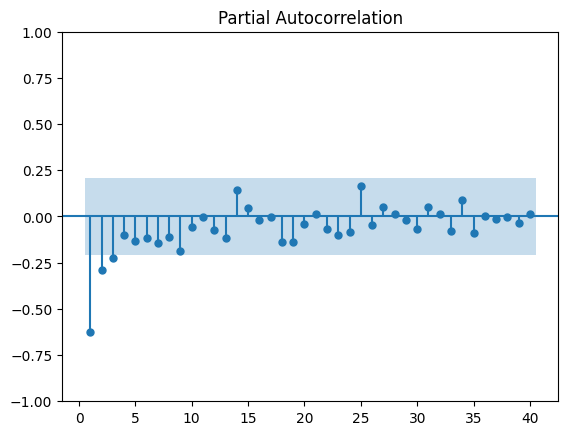

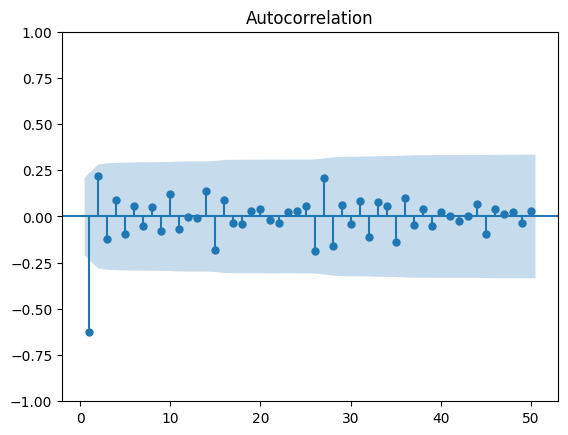

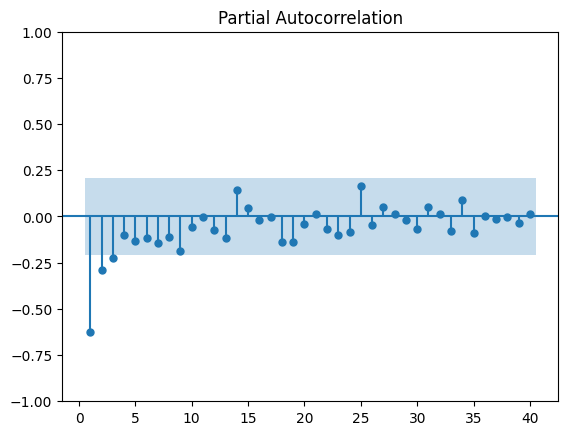

In [112]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(attrition_diff,zero=False, lags=50)
plot_pacf(attrition_diff,zero=False, lags=40)


c:\Users\Ard Al Jood\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ard Al Jood\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ard Al Jood\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:         AttritionCount   No. Observations:                   87
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -155.978
Date:                Thu, 08 May 2025   AIC                            317.957
Time:                        12:12:28   BIC                            325.355
Sample:                             0   HQIC                           320.936
                                 - 87                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0508      0.099      0.514      0.607      -0.143       0.245
ar.L1         -0.6222      0.087     -7.160      0.000      -0.793      -0.452
sigma2         2.1005      0.347      6.062      0.0

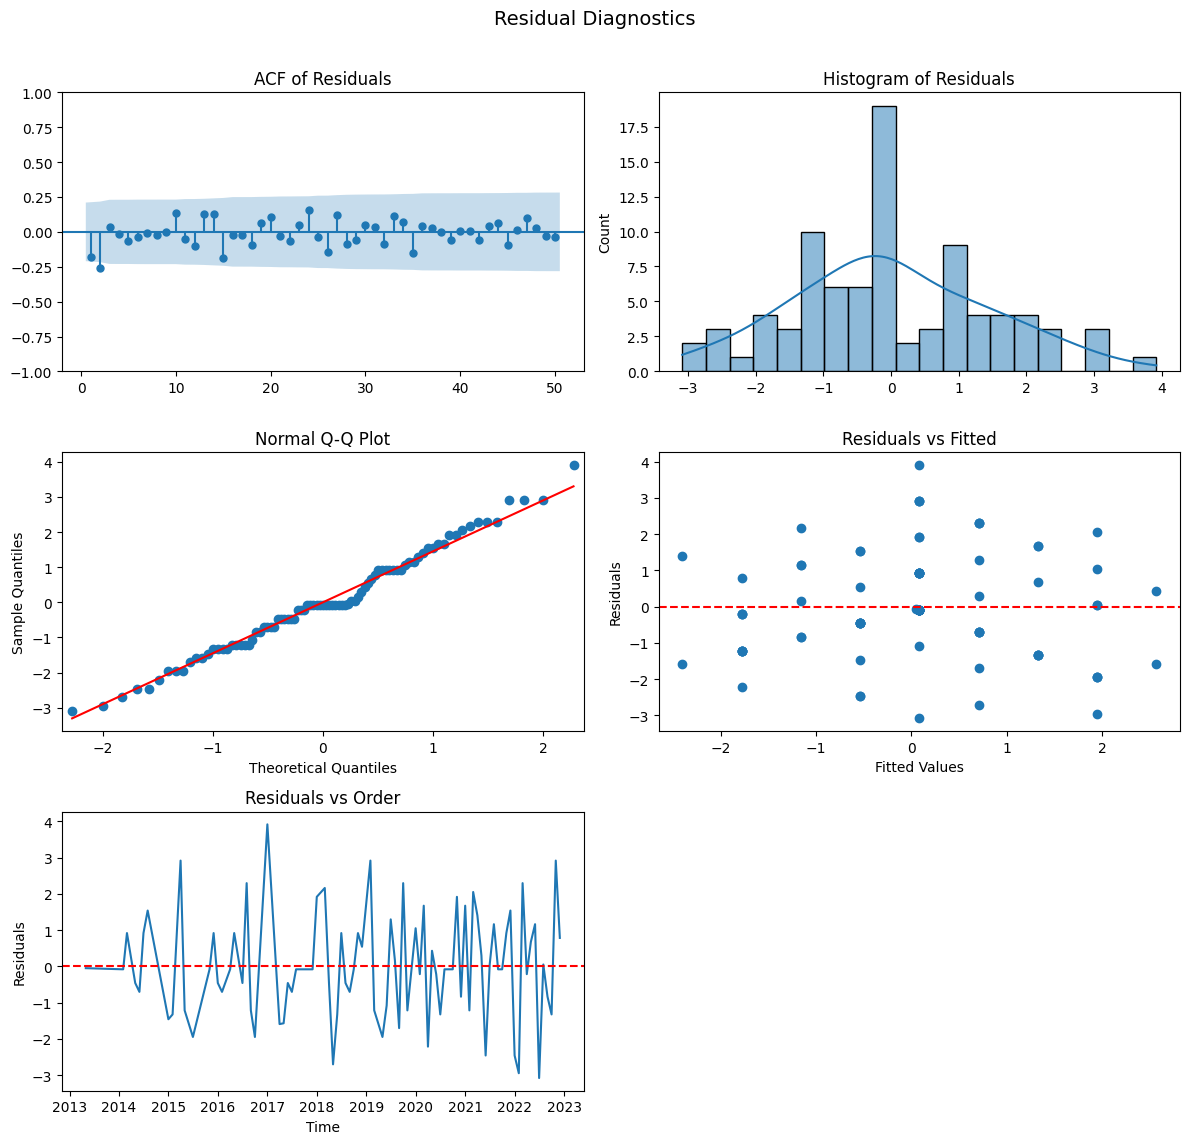

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA(1,0,0) model
model = ARIMA(attrition_time_series, order=(1,1,0))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())
# Get residuals
fit = model_fit



# Residuals
residuals = fit.resid

# Fitted values (drop nan to match residuals)
fitted_vals = fit.fittedvalues




fig, axes = plt.subplots(3, 2, figsize=(12, 12))
fig.suptitle("Residual Diagnostics", fontsize=14)

# ACF plot
plot_acf(residuals, lags=50,zero=False, ax=axes[0, 0])
axes[0, 0].set_title("ACF of Residuals")

# Histogram
sns.histplot(residuals, kde=True, bins=20, ax=axes[0, 1])
axes[0, 1].set_title("Histogram of Residuals")

# Q-Q plot
qqplot(residuals, line='s', ax=axes[1, 0])
axes[1, 0].set_title("Normal Q-Q Plot")

# Residuals vs Fitted
axes[1, 1].scatter(fitted_vals, residuals)
axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].set_title("Residuals vs Fitted")
axes[1, 1].set_xlabel("Fitted Values")
axes[1, 1].set_ylabel("Residuals")

# Residuals vs Order (Time)
axes[2, 0].plot(residuals)
axes[2, 0].axhline(0, color='red', linestyle='--')
axes[2, 0].set_title("Residuals vs Order")
axes[2, 0].set_xlabel("Time")
axes[2, 0].set_ylabel("Residuals")

# Turn off empty subplot
axes[2, 1].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


In [152]:
residuals

ExitMonth
2013-05-01   -0.050830
2014-02-01   -0.082456
2014-03-01    0.917544
2014-05-01   -0.460259
2014-06-01   -0.704653
                ...   
2022-08-01    0.050953
2022-09-01   -0.838061
2022-10-01   -1.326850
2022-11-01    2.917544
2022-12-01    0.784136
Length: 87, dtype: float64

In [114]:
from scipy import stats

# Perform Kolmogorov-Smirnov test for normality

# Standardize residuals
standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

# Perform K-S test
ks_statistic, p_value = stats.kstest(standardized_residuals, 'norm')

print("Kolmogorov-Smirnov Test Results:")
print(f"KS Statistic: {ks_statistic:.4f}")
print(f"p-value: {p_value:.4f}")
print("\nNull Hypothesis: The residuals follow a normal distribution")
print(f"Result: {'Fail to reject' if p_value > 0.05 else 'Reject'} the null hypothesis at 5% significance level")

Kolmogorov-Smirnov Test Results:
KS Statistic: 0.1116
p-value: 0.2123

Null Hypothesis: The residuals follow a normal distribution
Result: Fail to reject the null hypothesis at 5% significance level


In [115]:
from scipy.stats import norm

def runs_test_on_residuals(residuals):
    residuals = np.array(residuals)
    median = np.median(residuals)
    
    # Convert to binary: 1 if above median, 0 otherwise
    binary_seq = [1 if val > median else 0 for val in residuals]
    
    # Count runs
    runs = 1
    for i in range(1, len(binary_seq)):
        if binary_seq[i] != binary_seq[i - 1]:
            runs += 1

    n1 = binary_seq.count(1)
    n2 = binary_seq.count(0)
    total = n1 + n2

    if n1 == 0 or n2 == 0:
        return "All residuals are on one side of the median. Runs test not valid."

    # Expected runs and standard deviation
    expected_runs = (2 * n1 * n2) / total + 1
    std_dev = np.sqrt((2 * n1 * n2 * (2 * n1 * n2 - n1 - n2)) / (total**2 * (total - 1)))

    # Z and p-value
    z = (runs - expected_runs) / std_dev
    p_value = 2 * (1 - norm.cdf(abs(z)))

    # Results
    return {
        'number_of_runs': runs,
        'expected_runs': expected_runs,
        'z_score': z,
        'p_value': p_value,
        'above_median': n1,
        'below_median': n2,
        'total_residuals': total
    }
runs_test_on_residuals(residuals)



{'number_of_runs': 51,
 'expected_runs': 43.52873563218391,
 'z_score': np.float64(1.6486472383908644),
 'p_value': np.float64(0.09921992512332056),
 'above_median': 37,
 'below_median': 50,
 'total_residuals': 87}

In [116]:
# Print descriptive statistics of residuals
print("\nResiduals Statistics:")
print(residuals.describe())
ssr = (residuals ** 2).sum()
mse = (residuals ** 2).mean()
print(f"\nMean Squared Error (MSE): {mse}")
# Residual Sum of Squares
print(f"\nResidual Sum of Squares (RSS): {ssr}")



Residuals Statistics:
count    87.000000
mean     -0.000357
std       1.457738
min      -3.082456
25%      -1.149160
50%      -0.082456
75%       0.917544
max       3.917544
dtype: float64

Mean Squared Error (MSE): 2.1005747683036

Residual Sum of Squares (RSS): 182.75000484241318


In [117]:
def grubbs_test(residuals):
   n = len(residuals)
   mean_x = np.mean(residuals)
   sd_x = np.std(residuals)
   numerator = max(abs(residuals-mean_x))
   g_calculated = numerator/sd_x
   print("Grubbs Calculated Value:",g_calculated)
   t_value_1 = stats.t.ppf(1 - 0.05 / (2 * n), n - 2)
   g_critical = ((n - 1) * np.sqrt(np.square(t_value_1))) / (np.sqrt(n) * np.sqrt(n - 2 + np.square(t_value_1)))
   print("Grubbs Critical Value:",g_critical)
   if g_critical > g_calculated:
      print("We can see from the Grubbs test that the calculated value is less than the crucial value. Recognize the null hypothesis and draw the conclusion that there are no outliers\n")
   else:
      print("We see from the Grubbs test that the estimated value exceeds the critical value. Reject the null theory and draw the conclusion that there are outliers\n")
grubbs_test(residuals)


Grubbs Calculated Value: 2.7032387258685646
Grubbs Critical Value: 3.33586874110182
We can see from the Grubbs test that the calculated value is less than the crucial value. Recognize the null hypothesis and draw the conclusion that there are no outliers



In [ ]:


# Step 2: Fit model on differenced data
model = ARIMA(attrition_time_series, order=(1, 1, 0))  # (p,d,q) where d=0 because we already differenced

fitted_model = model.fit()

# Step 3: Forecast the differenced series
n_periods = 12
forecast_diff = fitted_model.forecast(steps=n_periods)

# Step 4: Invert differencing
last_actual = attrition_time_series.iloc[-1]
forecast_original = forecast_diff.cumsum() + last_actual



print("\nForecast on original scale:")
print(forecast_original)



Forecast on original scale:
87    5.704653
88    5.348675
89    5.652619
90    5.545962
91    5.694779
92    5.684641
93    5.773405
94    5.800632
95    5.866147
96    5.907839
97    5.964354
98    6.011646
Name: predicted_mean, dtype: float64


c:\Users\Ard Al Jood\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ard Al Jood\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ard Al Jood\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ard Al Jood\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: N

C:\Users\Ard Al Jood\AppData\Local\Temp\ipykernel_9924\3597715856.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=attrition_time_series.index[-1] + pd.offsets.MonthEnd(1), periods=n_periods, freq='M')


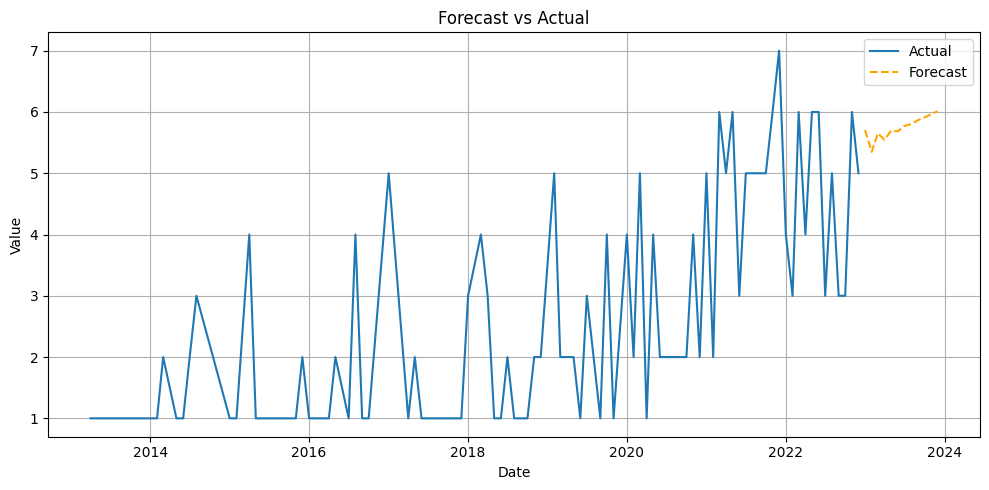

In [119]:
forecast_index = pd.date_range(start=attrition_time_series.index[-1] + pd.offsets.MonthEnd(1), periods=n_periods, freq='M')
forecast_series = pd.Series(forecast_original.values, index=forecast_index)
combined = pd.concat([attrition_time_series, forecast_series])

# 6. Plot
plt.figure(figsize=(10, 5))
plt.plot(attrition_time_series, label='Actual')
plt.plot(forecast_series, label='Forecast', linestyle='--', color='orange')
plt.title('Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [120]:

def time_series_accuracy(actual_values, forecast_original_scale):
    y_true = np.array(actual_values)
    y_pred = np.array(forecast_original_scale)

    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    
    # Avoid division by zero
    mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-10, y_true))) * 100
    
    # Symmetric MAPE
    smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape,
        'sMAPE (%)': smape
    }


In [121]:
accuracy = time_series_accuracy(actual_values, forecast_original_scale)

for metric, value in accuracy.items():
    print(f"{metric}: {value:.2f}")

MAE: 0.96
RMSE: 1.17
MAPE (%): 24.21
sMAPE (%): 22.62


In [122]:
# Set forecast horizon
h = 5

# Trim the differenced and original series to leave out the last 5 values
diff_train = attrition_diff[:-h]
original_train = attrition_time_series[:-h]
actual_values = attrition_time_series[-h:]

# Fit ARIMA(1,0,0) on the truncated differenced series 
model = ARIMA(diff_train, order=(1, 0, 0))
model_fit = model.fit()

# Forecast the next 5 steps in the differenced series
diff_forecast = model_fit.forecast(steps=h)

# Get the last known value from the truncated original series
last_value = original_train[-1]

# Invert the differencing
forecast_original_scale = np.r_[last_value, diff_forecast].cumsum()[1:]

# Show side-by-side comparison
results = pd.DataFrame({
    'Actual': actual_values,
    'Forecast': forecast_original_scale
})

print(results)

# Calculate accuracy metrics
accuracy = time_series_accuracy(actual_values, forecast_original_scale)

for metric, value in accuracy.items():
    print(f"{metric}: {value:.2f}")

            Actual  Forecast
ExitMonth                   
2022-08-01       5  4.963022
2022-09-01       3  3.783740
2022-10-01       3  4.593987
2022-11-01       6  4.144577
2022-12-01       5  4.492710
MAE: 0.96
RMSE: 1.17
MAPE (%): 24.21
sMAPE (%): 22.62


c:\Users\Ard Al Jood\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ard Al Jood\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ard Al Jood\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Ard Al Jood\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: N